
# Asteroid Radar Image Classification — Final Notebook

**Research Question:**  
*Can combining an image-based CNN with a metadata-based Random Forest improve the accuracy and reliability of asteroid image classification?*




## 1. Configuration

In [ ]:

from pathlib import Path


DATA_DIR = Path(r"C:\Users\Jacks\OneDrive\Desktop\Asteroid Image\asteroid_frames")
METADATA_CSV = DATA_DIR / "metadata.csv"

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
SEED = 42

print("DATA_DIR:", DATA_DIR)
print("METADATA_CSV:", METADATA_CSV)
print("OUT_DIR:", OUT_DIR.resolve())


DATA_DIR: C:\Users\Jacks\OneDrive\Desktop\Asteroid Image\asteroid_frames
METADATA_CSV: C:\Users\Jacks\OneDrive\Desktop\Asteroid Image\asteroid_frames\metadata.csv
OUT_DIR: C:\Users\Jacks\OneDrive\Desktop\Asteroid Image\outputs


## 2. Metadata Classification

In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import json

df_meta = pd.read_csv(METADATA_CSV)

num_features = ['brightness_mean','brightness_std','brightness_median',
                'bright_fraction','edge_density','contrast_p5_95','entropy']
target_col = 'brightness_bin'

assert target_col in df_meta.columns, f"Target column '{target_col}' not found in metadata.csv"

X = df_meta[num_features].copy()
y = df_meta[target_col].copy()

SEED = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

pre = ColumnTransformer([('num', StandardScaler(), num_features)], remainder='drop')
rf  = RandomForestClassifier(random_state=SEED, n_jobs=-1)

param_grid = {
    'rf__n_estimators': [150, 300, 500],
    'rf__max_depth': [None, 10, 20]
}

pipe = Pipeline([('pre', pre), ('rf', rf)])
grid = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
rf_acc = float(accuracy_score(y_test, y_pred))

print("Best RF params:", grid.best_params_)
print("Random Forest Accuracy (test):", round(rf_acc, 4))
print("\nClassification Report (test):\n", classification_report(y_test, y_pred))

rf_metrics = {
    "model": "Random Forest (metadata)",
    "target": target_col,
    "accuracy": rf_acc,
    "best_params": grid.best_params_,
    "cv_best_score": float(grid.best_score_),
    "feature_list": num_features
}
with open(OUT_DIR / "rf_metrics.json", "w") as f:
    json.dump(rf_metrics, f, indent=2)
with open(OUT_DIR / "rf_accuracy.txt", "w") as f:
    f.write(str(rf_acc))


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best RF params: {'rf__max_depth': None, 'rf__n_estimators': 150}
Random Forest Accuracy (test): 0.9608

Classification Report (test):
               precision    recall  f1-score   support

        High       1.00      0.94      0.97        17
         Low       0.94      1.00      0.97        17
         Med       0.94      0.94      0.94        17

    accuracy                           0.96        51
   macro avg       0.96      0.96      0.96        51
weighted avg       0.96      0.96      0.96        51



### 3 Confusion Matrix (Random Forest)

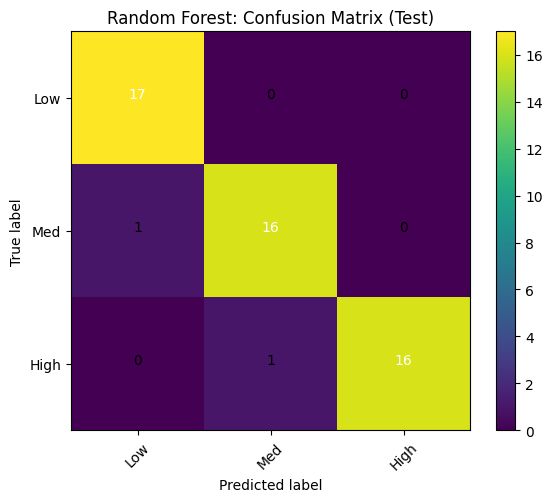

In [3]:

import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

labels = ["Low","Med","High"]
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Random Forest: Confusion Matrix (Test)')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

fmt = 'd'
thresh = cm.max() / 2.0 if cm.size else 0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             ha="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


## 4. Image Classification (CNN)

In [4]:

import tensorflow as tf
from collections import Counter

def make_dataset(directory, image_size, batch_size, shuffle=True, seed=SEED):
    return tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        image_size=image_size,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed
    )

train_ds = make_dataset(DATA_DIR / "train", IMG_SIZE, BATCH_SIZE, shuffle=True)
val_ds   = make_dataset(DATA_DIR / "val",   IMG_SIZE, BATCH_SIZE, shuffle=False)
test_ds  = make_dataset(DATA_DIR / "test",  IMG_SIZE, BATCH_SIZE, shuffle=False)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names, "  (num_classes =", num_classes, ")")

cnt_train = Counter(int(y.numpy()) for _, y in train_ds.unbatch())
cnt_val   = Counter(int(y.numpy()) for _, y in val_ds.unbatch())
cnt_test  = Counter(int(y.numpy()) for _, y in test_ds.unbatch())
print("Train counts:", cnt_train)
print("Val counts:", cnt_val)
print("Test counts:", cnt_test)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.2),
], name="augmentation")


Found 360 files belonging to 2 classes.
Found 81 files belonging to 2 classes.
Found 73 files belonging to 2 classes.
Classes: ['asteroid', 'background']   (num_classes = 2 )
Train counts: Counter({0: 180, 1: 180})
Val counts: Counter({0: 41, 1: 40})
Test counts: Counter({1: 40, 0: 33})


### 4.1 Model Definition and Training

In [5]:

from tensorflow.keras import layers, models
import json

inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

cnn = models.Model(inputs, outputs, name="cnn_baseline")

USE_LABEL_SMOOTHING = False
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(label_smoothing=0.05) if USE_LABEL_SMOOTHING else 'sparse_categorical_crossentropy'

cnn.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
cnn.summary()

best_path = OUT_DIR / "cnn_best.keras"
ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(best_path),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[ckpt, es],
    verbose=1
)

with open(OUT_DIR / "cnn_history.json", "w") as f:
    json.dump({k: list(map(float, v)) for k, v in history.history.items()}, f)


Model: "cnn_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,784,130 (98.36 MB)

 Trainable params: 25,784,130 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.4933 - loss: 2.8349
Epoch 1: val_accuracy improved from None to 0.77778, saving model to outputs\cnn_best.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 580ms/step - accuracy: 0.5556 - loss: 1.9515 - val_accuracy: 0.7778 - val_loss: 0.4561
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.7957 - loss: 0.4327
Epoch 2: val_accuracy improved from 0.77778 to 0.83951, saving model to outputs\cnn_best.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 518ms/step - accuracy: 0.8556 - loss: 0.3877 - val_accuracy: 0.8395 - val_loss: 0.2685
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9519 - loss: 0.1538
Epoch 3: val_accuracy improved from 0.83951 to 0.92593, saving model to outputs\cnn_best.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 521ms/step - accuracy: 0.9667 - loss: 0.1261 - val_accuracy: 0.9259 - val_loss: 0.1724
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 1.0000 - loss: 0.0271
Epoch 4: val_accuracy i

### 4.2 Training Curves

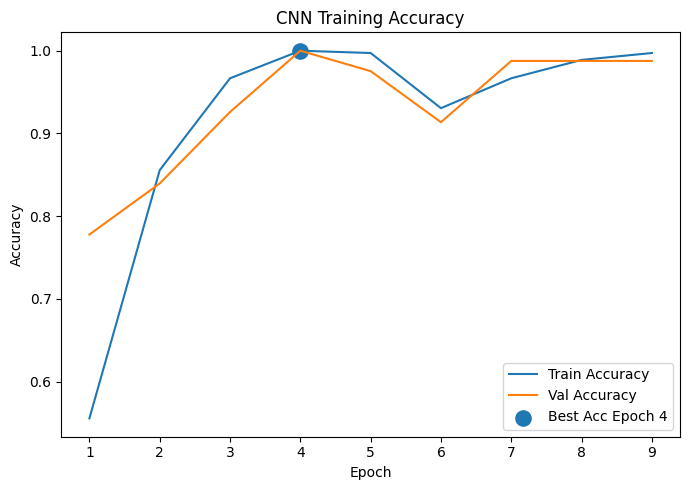

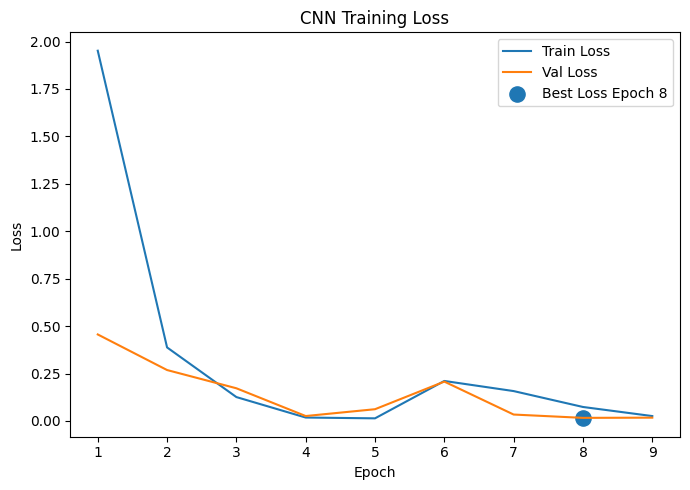

Best accuracy epoch: 4 Val Acc: 1.0
Best loss epoch: 8 Val Loss: 0.0165


In [6]:

import matplotlib.pyplot as plt
import numpy as np

tr_acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
tr_loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

epochs = np.arange(1, len(tr_acc) + 1) if tr_acc else []

best_acc_epoch = int(np.argmax(val_acc)) + 1 if len(val_acc) else None
best_loss_epoch = int(np.argmin(val_loss)) + 1 if len(val_loss) else None

plt.figure(figsize=(7,5))
if len(epochs):
    plt.plot(epochs, tr_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    if best_acc_epoch is not None:
        plt.scatter(best_acc_epoch, val_acc[best_acc_epoch-1], s=120, label=f'Best Acc Epoch {best_acc_epoch}')
plt.title('CNN Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
if len(epochs):
    plt.plot(epochs, tr_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    if best_loss_epoch is not None:
        plt.scatter(best_loss_epoch, val_loss[best_loss_epoch-1], s=120, label=f'Best Loss Epoch {best_loss_epoch}')
plt.title('CNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

if best_acc_epoch is not None:
    print("Best accuracy epoch:", best_acc_epoch, "Val Acc:", round(val_acc[best_acc_epoch-1], 4))
if best_loss_epoch is not None:
    print("Best loss epoch:", best_loss_epoch, "Val Loss:", round(val_loss[best_loss_epoch-1], 4))


### 4.3 Test Evaluation and Confusion Matrix

Test Accuracy: 0.9863  Test Loss: 0.0255

Classification Report (Test):
               precision    recall  f1-score   support

    asteroid       0.97      1.00      0.99        33
  background       1.00      0.97      0.99        40

    accuracy                           0.99        73
   macro avg       0.99      0.99      0.99        73
weighted avg       0.99      0.99      0.99        73



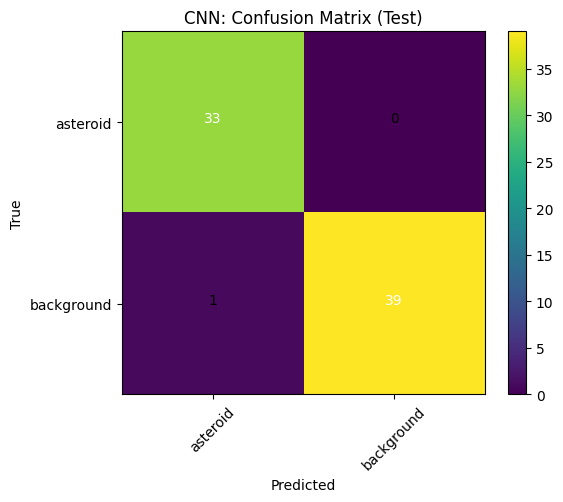

In [7]:

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np, matplotlib.pyplot as plt, itertools, json

test_loss, test_acc = cnn.evaluate(test_ds, verbose=0)
print("Test Accuracy:", round(float(test_acc), 4), " Test Loss:", round(float(test_loss), 4))

y_true, y_pred = [], []
for images, labels in test_ds:
    probs = cnn.predict(images, verbose=0)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(probs, axis=1).tolist())

y_true = np.array(y_true); y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
print("\nClassification Report (Test):\n", classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('CNN: Confusion Matrix (Test)')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
thresh = cm.max()/2 if cm.size else 0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], ha="center", color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout(); plt.show()

# Save CNN metrics
cnn_metrics = {
    "model": "CNN (images)",
    "metric": "Test Accuracy",
    "test_accuracy": float(test_acc),
    "test_loss": float(test_loss)
}
with open(OUT_DIR / "cnn_metrics.json", "w") as f:
    json.dump(cnn_metrics, f, indent=2)


## 5. Summary of Key Metrics

In [8]:

import json, pandas as pd

rows = []
try:
    with open(OUT_DIR / "rf_metrics.json") as f:
        rf = json.load(f)
    rows.append({"Model": rf.get("model","Random Forest"), "Metric": "Accuracy", "Value": rf.get("accuracy", None)})
except Exception as e:
    print("RF metrics not found:", e)

try:
    with open(OUT_DIR / "cnn_metrics.json") as f:
        cm = json.load(f)
    rows.append({"Model": cm.get("model","CNN"), "Metric": cm.get("metric","Test Accuracy"), "Value": cm.get("test_accuracy", None)})
except Exception as e:
    print("CNN metrics not found:", e)

summary_df = pd.DataFrame(rows, columns=["Model","Metric","Value"])
summary_path = OUT_DIR / "final_metrics_summary.csv"
summary_df.to_csv(summary_path, index=False)
summary_df


,Model,Metric,Value
0,Random Forest (metadata),Accuracy,0.960784
1,CNN (images),Test Accuracy,0.986301
